In [617]:
import numpy as np
import json
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import math


class Activation_Function(Enum):
    """
    Activation Function Enums
    """

    LINEAR = 1
    RELU = 2
    SIGMOID = 3
    SOFTMAX = 4


def relu(v: float):
    return max(0, v)


def sigmoid(v: float):
    return 1 / (1 + math.exp(-v))

def softmax(v: float):
    e_v = np.exp(v - np.max(v)) 
    return e_v / e_v.sum(axis=0)


"""
Vectorizing activation functions so
functions can be easily applied to ndarrays
"""
reluVect = np.vectorize(relu)
sigmoidVect = np.vectorize(sigmoid)
softmaxVect = np.vectorize(softmax)

"""
Layer object class
"""
class Layer:
    def __init__(self, w: np.ndarray, activ_func: Activation_Function) -> None:
        if (w.ndim != 2):
            raise RuntimeError("Layer initialized with non 2-dimensional array")

        self.w = w
        self.n_inputs = w.shape[0]
        self.n_neurons = w.shape[1]
        self.activ_func = activ_func


"""
Feed Forward Neural Network object class
"""
class FFNN:
    def __init__(self, input_size: int) -> None:
        self._input_size = input_size
        self._input: list[list[float]] = []
        self._layers: list[Layer] = []

    def addInput(self, newInput: list[float]):
        if self._input_size != len(newInput):
            raise RuntimeError("Added input that is different from input_size")

        self._input.append(newInput)

    def addLayer(self, newLayer: Layer):
        if len(self._input) == 0:
            raise RuntimeError("Input not defined before adding hidden layer")

        if (
            len(self._layers) == 0 and (len(self._input[0]) + 1) != newLayer.n_inputs
        ) or (len(self._layers) != 0 and (self._layers[-1].n_neurons + 1) != newLayer.n_inputs):
            raise RuntimeError(
                "Number of inputs in layer matrix does not match output from previous layer"
            )

        self._layers.append(newLayer)

    def run(self):
        """
        Works by iterating through each layer's weight matrix
        
        net = wT * x
        wT = current layer weight transposed
        x = current input/hidden layer results

        For each iteration, x will have bias (1.0) values appended 
        """
        current = np.array(self._input).transpose()
        bias = np.array([[1.0 for _ in self._input]])

        for layer in self._layers:
            current = np.concatenate((bias, current), axis=0)

            new_current = layer.w.transpose() @ current
            current = new_current
            
            if layer.activ_func == Activation_Function.RELU:
                current = reluVect(current)
            elif layer.activ_func == Activation_Function.SIGMOID:
                current = sigmoidVect(current)
            elif layer.activ_func == Activation_Function.SOFTMAX:
                current = softmaxVect(current)

        return current.transpose()
    
    def draw_network(self, save_path="ffnn_graph.png") -> None:
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_aspect('equal')
            ax.axis('off')

            # Define node positions
            node_spacing = 1.0
            
            #generating node x position for each layer[layer1,layer2,layer3]
            nodes_x = np.arange(len(self._layers)+2)
            
            #adjust distance for each layer
            layer_spacing = 1
            for i in range(len(nodes_x)):
                if(i != 0):
                    nodes_x[i] += (i*layer_spacing)
            
            #generating node y position for each layer and node [[layer1 node1, layer1 node2],[layer2 node1, layer2 node2],[]]
            nodes_y = []
            
            # Plot nodes for input layer
            nodes_y.append(np.arange(self._input_size) * node_spacing - 
                                ((self._input_size - 1) * node_spacing / 2))
            for i in range(self._input_size):
                ax.plot(nodes_x[0], nodes_y[0][i], 'go', markersize=10)

            
            # Plot nodes for hidden layers
            for i, layer in enumerate(self._layers):
                nodes_y.append(np.arange(layer.n_neurons) * node_spacing - 
                            ((layer.n_neurons - 1) * node_spacing / 2))
                for j in range(layer.n_neurons):
                    ax.plot(nodes_x[i+1], nodes_y[i+1][j], 'bo', markersize=10)
                    if i==0 :  # Connect nodes to input layer
                        for k in range(self._input_size):  # Iterate over nodes in input layer
                            ax.plot([nodes_x[i+1],nodes_x[i]], [nodes_y[i + 1][j],nodes_y[0][k]], 'k-')
                            
                    if i > 0: # Connect nodes to previous layer
                        for k in range(self._layers[i-1].n_neurons):  # Iterate over nodes in hidden layers
                            ax.plot([nodes_x[i+1],nodes_x[i]], [nodes_y[i + 1][j],nodes_y[i][k]], 'k-')
                            

            output_layers=self.run()
            # Plot nodes for output layer
            for j, output in enumerate(output_layers[0]):
                nodes_y.append(np.arange(len(output_layers[0])) * node_spacing - 
                                ((len(output_layers[0]) - 1) * node_spacing / 2))
                
                ax.plot(nodes_x[-1], nodes_y[-1][j], 'ro', markersize=10)
                # Connect last hidden layer nodes to output layer
                for k in range(len(output_layers[0])):
                        ax.plot([nodes_x[-1],nodes_x[-2]], [nodes_y[-1][k],nodes_y[-2][j]], 'k-')

            plt.show()
            print("""
Input Layer: Green
Hidden Layer : Blue
Output Layer : Red
                  """)
            plt.close()



def readfile(filename):
    try:
        with open(filename, 'r') as file:
            loader = json.load(file)
        
        model_info = loader.get("case", {})
        model = model_info.get("model")
        weights = model_info.get("weights")
        inputs = model_info.get("input")

        ffnn = FFNN(model.get('input_size'))
        
        # Iterate through each layer in the model
        for i in range(len(inputs)):
            ffnn.addInput(inputs[i])
        for i, layer_info in enumerate(model['layers']):
            layer = Layer(np.array(weights[i]), layer_info['activation_function'])
            ffnn.addLayer(layer)

        return ffnn            

    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
    except json.JSONDecodeError:
        print(f"Error: The file '{filename}' does not contain valid JSON.")
    except KeyError as e:
        print(f"Error: Missing expected key {e} in the JSON structure.")




Output : [ 3.022  1.738 -0.442]


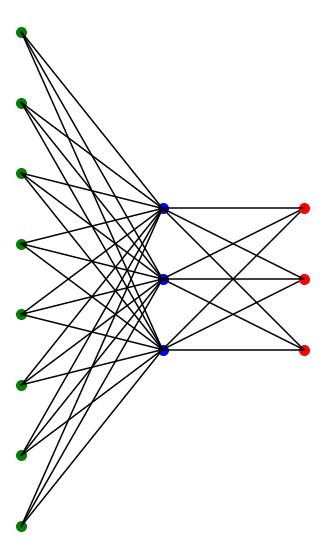


Input Layer: Green
Hidden Layer : Blue
Output Layer : Red
                  


In [618]:
ffnn = readfile("models/softmax.json")
print(f"Output : {ffnn.run()[0]}")
ffnn.draw_network()